In [87]:
from collections import Counter
from datetime import datetime
from glob import glob
import os
from pathlib import Path

from fastcore.xtras import load_pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pycm import ConfusionMatrix
from scipy.stats import sem
from sklearn import metrics

RED_TINTS = [
    "green", 
    "#FF1919", 
    "#FF3232",  
    "#FF4C4C",  
    "#FF6666",  
    "#FF7F7F",  
    "#FF9999",  
    "#FFB2B2",  
    "#FFCCCC", 
    "#FFE5E5",  
    "#FFDFDF",  
    "#FFD9D9",  
    "#FFD3D3",
    "#FFCDCD",  
    "#FFC7C7", 
    "#FFC1C1", 
    "#FFBBBB"   
]

FOLDER = 'LLM_result'

plt.style.use("style.mplstyle")


In [88]:
if not os.path.exists(FOLDER):
    raise FileExistsError('Cannot find folder {}'.format(FOLDER))

all_res = glob(f'{FOLDER}/*.pkl')
print('Pickles found in {}: {}'.format(FOLDER, len(all_res)))

Pickles found in LLM_result: 1


In [89]:
compiled_res_list = []
conf_mats = []

for results in all_res:
    print(results)
    res_full = load_pickle(results)
    res = res_full['results']
    summary = {
        'size': res_full['train_size'],
        'representation': res_full['data_summary']['representation'],
        'accuracy': res['accuracy'],
        'f1_macro': res['f1_macro'],
        'f1_micro': res['f1_micro'],
        'kappa': res['kappa'],
        'num_epochs': res_full['config']['tune_settings']['num_train_epochs'],
        'lr': res_full['config']['tune_settings']['learning_rate'],
        'bins': len(set(res['all_y_true']))
       
    }
    confusion_matrix = {
        'all_y_true':res['all_y_true'],
        'all_y_pred':res['all_y_pred']
    }
    conf_mats.append(confusion_matrix)
    compiled_res_list.append(summary)

LLM_result/20240123-161326_300_200_predictions.pkl


In [90]:
compiled_res = pd.DataFrame(compiled_res_list)
display(compiled_res)

,size,representation,accuracy,f1_macro,f1_micro,kappa,num_epochs,lr,bins
0,300,synthesis_noSolvPerc,0.8,0.794745,0.8,0.59217,200,0.0003,2


# Plot Confusion Matrix

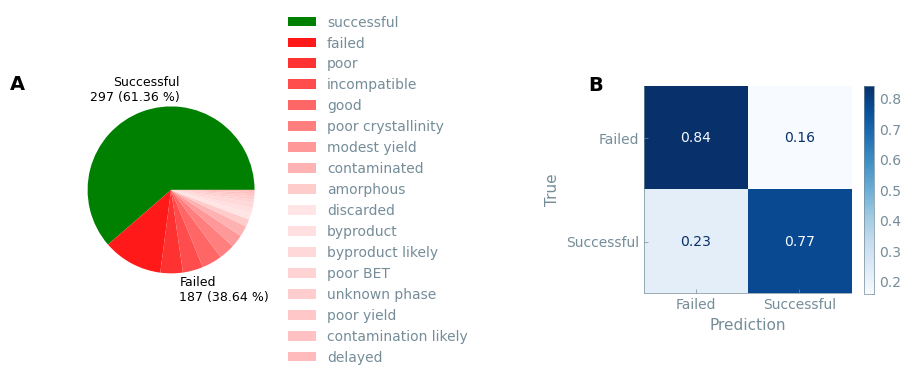

In [92]:
fig, ax = plt.subplots(1,2, tight_layout = True, figsize = (10,4))
axs = ax.flatten()

values, confusion_matrix_values = compiled_res_list[0], conf_mats[0]
acc = values['accuracy']

# Create Confusion Matrix
trues, preds = confusion_matrix_values['all_y_true'], confusion_matrix_values['all_y_pred']
confusion_matrix = metrics.confusion_matrix(trues, preds)
confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_normalized, display_labels = ['Failed', 'Successful'])
cm_display.plot(cmap=plt.cm.Blues, ax=axs[1])
axs[1].set_xlabel('Prediction')
axs[1].set_ylabel('True')


df_b = pd.read_csv('20240402_syntheses_UTF8.csv')
outcome_counter = Counter(df_b['outcome'])
outcome_counter = dict(sorted(outcome_counter.items(), key=lambda item: item[1], reverse=True))

sizes = outcome_counter.values()
labels = outcome_counter.keys()
labels_pie = [''] *len(labels)

n_succesfull = c['successful']
n_unsuccesfull = len(df_b) - n_succesfull
labels_pie[0] = f'Successful\n{n_succesfull} ({round(100 *(n_succesfull/len(df_b)), 2)} %)'
labels_pie[2] = f'Failed\n{n_unsuccesfull} ({round(100 *(n_unsuccesfull/len(df_b)), 2)} %)'

wedges, texts = axs[0].pie(sizes, labels= labels_pie, colors= RED_TINTS)
texts[2].set_position((0.1, -1.2))
texts[0].set_position((0.1, 1.2))


axs[0].legend(wedges, labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(texts, 
    size=9, 
    color='k')


plt.tight_layout(pad=5) 

axs[0].text(-0.2, 1.05, 'A', transform=axs[0].transAxes,
         fontsize=14, fontweight='bold', va='top', ha='right', c= 'k')
axs[1].text(-0.2, 1.05, 'B', transform=axs[1].transAxes,
         fontsize=14, fontweight='bold', va='top', ha='right',c = 'k')

plt.savefig('predicting_LLM.png')